### (H) Convolutional neural network

#### Instructions

You tested above different models with the set of high-level features extracted from a **pretrained neural network**. However, **can you get similar results by creating a ConvNet from scratch** and using the pixel values from the original images to train the model?

1. What accuracy can you achieve?
2. Can you get good results? - If not, why?

#### Task H

* No need to load data as has been done at the top of the notebook
* No need to rescale data as has been done in initial notebook
* Define a get_batches(X, y, batch_size) function to generate random X/y batches of size batch_size using a Python generator.

#### Load data

In [1]:
import numpy as np
import pandas as pd

In [2]:
with np.load('swissroads_highlevel_features.npz', allow_pickle=False) as npz_file:
    # Load the arrays
    features_tr = npz_file['features_train']
    labels_tr = npz_file['labels_train']
    features_va = npz_file['features_valid']
    labels_va = npz_file['labels_valid']
    features_te = npz_file['features_test']
    labels_te = npz_file['labels_test']
    imgs_tr = npz_file['imgs_train']
    imgs_va = npz_file['imgs_valid']
    imgs_te = npz_file['imgs_test']

print('features_tr:', features_tr.shape)
print('labels_tr:', labels_tr.shape)
print('features_va:', features_va.shape)
print('labels_va:', labels_va.shape)
print('features_te:', features_te.shape)
print('labels_te:', labels_te.shape)
print('imgs_tr:', imgs_tr.shape)
print('imgs_va:', imgs_va.shape)
print('imgs_te:', imgs_te.shape)

features_tr: (280, 2048)
labels_tr: (280,)
features_va: (139, 2048)
labels_va: (139,)
features_te: (50, 2048)
labels_te: (50,)
imgs_tr: (280, 299, 299, 3)
imgs_va: (139, 299, 299, 3)
imgs_te: (50, 299, 299, 3)


In [3]:
X_tr = features_tr
X_va = features_va
X_te = features_te
y_tr = labels_tr
y_va = labels_va
y_te = labels_te
labels = ['bike','car','motorcycle','other','truck','van']

### Task H

In [4]:
# 4.8.6 Multilayer and Conventional neural networks

In [5]:
print('Train shape:',imgs_tr.shape)
print('Validation shape:',imgs_va.shape)
print('Test shape:',imgs_te.shape)

Train shape: (280, 299, 299, 3)
Validation shape: (139, 299, 299, 3)
Test shape: (50, 299, 299, 3)


In [6]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)
    
    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

**Greg note on Batches vs loop on full data set** *(from 4.7.5 Neural networks)*

*In the last unit, we trained the network by running the **training operation** a hundred times using the entire data set. In practice, we often need to train neural networks on large data sets, and it's usually not possible to run the graph using the entire data. In particular, we need to be careful when running our graphs using GPUs since they have smaller memories than CPUs. For this reason, we usually train neural networks by **small batches of data points**.*

*In the machine learning jargon, one pass of training through the entire training set is called an **epoch**. In practice, **we usually shuffle the data before each epoch to get better results**.*

In [7]:
# Use generator in a "for" loop
for X_batch, y_batch in get_batches(imgs_tr, y_tr, 32):
    print('Batch X/y:', X_batch.shape, y_batch.shape)

Batch X/y: (32, 299, 299, 3) (32,)
Batch X/y: (32, 299, 299, 3) (32,)
Batch X/y: (32, 299, 299, 3) (32,)
Batch X/y: (32, 299, 299, 3) (32,)
Batch X/y: (32, 299, 299, 3) (32,)
Batch X/y: (32, 299, 299, 3) (32,)
Batch X/y: (32, 299, 299, 3) (32,)
Batch X/y: (32, 299, 299, 3) (32,)
Batch X/y: (24, 299, 299, 3) (24,)


#### Create and Train ConvNet

* Create a convolutional neural network and train it using your batch generator
* Evaluate the accuracy on the validation set after each epoch
* Test different architectures and parameters
* Evaluate best network on the test set

The network has the following layers.

* Input layer with 299 by 299 RGB images from the swissroads data set
* Convolutional layer - 124 filters, 5x5 kernels, 2x2 strides, "same" padding and ReLU activation
* Maxpool layer - 2x2 pool size, 2x2 strides, "same" padding
* Convolutional layer - 64 filters, 3x3 kernels, 1x1 strides, "same" padding and ReLU activation
* Maxpool layer - 2x2 pool size, 2x2 stride, "same" padding
* Convolutional layer - 32 filters, 3x3 kernels, 1x1 strides, "same" padding and ReLU activation
* Maxpool layer - 2x2 pool size, 2x2 stride, "same" padding

We then flatten the output of this last pooling layer and get 1,024 units. We apply dropout to this flat layer and connect it to a final 2-layer "dense" network.

* Fully-connected layer with 512 units and ReLU activation
* Fully-connected layer with 128 units and ReLU activation
* Softmax regression layer with 6 output units

**perform feature extraction with the convolutional/maxpool layers and then classification with the fully-connected ones. Dropout added to the input of the fully-connected layers to let the classifier learn different aspects of the data and avoid overfitting.**

In [8]:
import tensorflow as tf

# Create new graph
graph = tf.Graph()

with graph.as_default():
    # Placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 299, 299, 3])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    print('Input:', X.shape)
    
    # Convolutional layer (64 filters, 5x5, stride: 2)
    conv1 = tf.layers.conv2d(
        X, 128, (5, 5), (2, 2), 'SAME', # "same" padding
        activation=tf.nn.relu, # ReLu
        kernel_initializer=tf.truncated_normal_initializer(stddev=0.01, seed=0),
        name='conv1'
    )
    print('Convolutional layer:', conv1.shape)
    
    # Maxpool layer (2x2, stride: 2, "same" padding)
    pool1 = tf.layers.max_pooling2d(conv1, (2, 2), (2, 2), "Same")
    print('Maxpool:', pool1.shape)
    
    # Convolutional layer (32 filters, 3x3, stride: 1)
    conv2 = tf.layers.conv2d(
        pool1, 64, (3, 3), (1, 1), "SAME",
        activation=tf.nn.relu,
        kernel_initializer=tf.truncated_normal_initializer(stddev=0.01, seed=0),
        name='conv2'
    )
    print('Convolutional layer:', conv2.shape)
    
    # Maxpool layer (2x2, stride: 2, "same" padding)
    pool2 = tf.layers.max_pooling2d(conv2, (2, 2), (2, 2), "Same")
    print('Maxpool:', pool2.shape)
    
    
    # Convolutional layer (24 filters, 3x3, stride: 1)
    conv3 = tf.layers.conv2d(
        pool2, 32, (3, 3), (1, 1), "SAME",
        activation=tf.nn.relu,
        kernel_initializer=tf.truncated_normal_initializer(stddev=0.01, seed=0),
        name='conv3'
    )
    print('Convolutional layer:', conv2.shape)
    
    # Maxpool layer (2x2, stride: 2, "same" padding)
    pool3 = tf.layers.max_pooling2d(conv3, (2, 2), (2, 2), "Same")
    print('Maxpool:', pool3.shape)
    
    
    # Flatten output
    flat_output = tf.contrib.layers.flatten(pool3)
    print('Flatten:', flat_output.shape)
    
    # Dropout
    training = tf.placeholder(dtype=tf.bool)
    flat_output = tf.layers.dropout(flat_output, rate=0.5, seed=0, training=training)
    print('Dropout:', flat_output.shape)
    
    # Fully connected layer
    fc1 = tf.layers.dense(
        flat_output, 512, # hidden units
        activation=tf.nn.relu, 
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer()
    )
    print('Fully connected layer:', fc1.shape)
    
    # Fully connected layer
    fc2 = tf.layers.dense(
        fc1, 128, # hidden units
        activation=tf.nn.relu, 
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer()
    )
    print('Fully connected layer:', fc2.shape)
    
    # Output layer
    logits = tf.layers.dense(
        fc2, 6, # One output unit per category
        activation=None, # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer()
    )
    print('Output layer:', logits.shape)
    
    # Kernel of the 1st conv. layer
    
    # Mean corss-entropy
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))
    
    # Adam optimizer
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.AdamOptimizer(learning_rate=lr)
    
    # Minimize cross-entropy
    train_op = gd.minimize(mean_ce)
    
    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    probabilities = tf.nn.softmax(logits)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

C:\Users\glaurent\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Input: (?, 299, 299, 3)
Convolutional layer: (?, 150, 150, 128)
Maxpool: (?, 75, 75, 128)
Convolutional layer: (?, 75, 75, 64)
Maxpool: (?, 38, 38, 64)
Convolutional layer: (?, 75, 75, 64)
Maxpool: (?, 19, 19, 32)
Flatten: (?, 11552)
Dropout: (?, 11552)
Fully connected layer: (?, 512)
Fully connected layer: (?, 128)
Output layer: (?, 6)


In [9]:
# Validation accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    # Set seed
    np.random.seed(0)
    
    # Train several epochs:
    for epoch in range(20): # tried with 20 but starts over fitting after 15
        # Accuracy values (train) after each batch
        batch_acc = []
        
        for X_batch, y_batch in get_batches(imgs_tr, labels_tr, 32):
            # Run training and evaluate accuracy
            _, acc_value= sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                lr: 0.001, # learning rate
                training: True
            })
            
            # Save accuracy (current batch)
            batch_acc.append(acc_value)
            
        # Evaluate validation accurcy
        valid_acc = sess.run(accuracy, feed_dict={
            X: imgs_va,
            y: labels_va,
            training: False
        })
        valid_acc_values.append(valid_acc)
        
        # Print progress
        print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))
        
    # Get 1st conv. layer kernels
    
    # Evalute test accuracy
    test_acc = sess.run(accuracy, feed_dict={
        X: imgs_te, 
        y: labels_te,
        training: False
    })
    print('Test accuracy: {:.3f}'.format(test_acc))

Epoch 1 - valid: 0.230 train: 0.177 (mean)
Epoch 2 - valid: 0.237 train: 0.227 (mean)
Epoch 3 - valid: 0.237 train: 0.234 (mean)
Epoch 4 - valid: 0.237 train: 0.230 (mean)
Epoch 5 - valid: 0.309 train: 0.295 (mean)
Epoch 6 - valid: 0.288 train: 0.324 (mean)
Epoch 7 - valid: 0.367 train: 0.339 (mean)
Epoch 8 - valid: 0.345 train: 0.412 (mean)
Epoch 9 - valid: 0.353 train: 0.484 (mean)
Epoch 10 - valid: 0.439 train: 0.447 (mean)
Epoch 11 - valid: 0.410 train: 0.508 (mean)
Epoch 12 - valid: 0.432 train: 0.545 (mean)
Epoch 13 - valid: 0.482 train: 0.565 (mean)
Epoch 14 - valid: 0.475 train: 0.612 (mean)
Epoch 15 - valid: 0.446 train: 0.634 (mean)
Epoch 16 - valid: 0.417 train: 0.634 (mean)
Epoch 17 - valid: 0.388 train: 0.663 (mean)
Epoch 18 - valid: 0.460 train: 0.791 (mean)
Epoch 19 - valid: 0.446 train: 0.821 (mean)
Epoch 20 - valid: 0.439 train: 0.829 (mean)
Test accuracy: 0.500


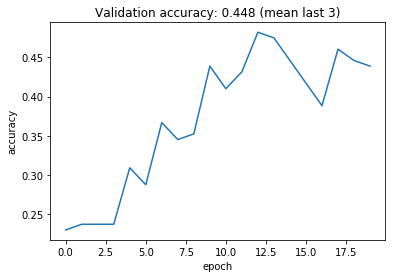

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(valid_acc_values)
plt.title('Validation accuracy: {:.3f} (mean last 3)'.format(
    np.mean(valid_acc_values[-3:]) # last three values
))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [11]:
%store test_acc

Stored 'test_acc' (float32)


#### Comments:
* Accuracy achieved is much lower to other estimators build from high level output features. From my understanding the main reason behind it is that the model used to extract high-level features has been built on a much larger data set and therefore is able to achieve better performance

#### Notes/Questions Task H (Greg)
* How to choose number of layers? How to choose number of filters, kernel_size, stride, ..? Does the initial size of the picture have an impact (299x299 vs 32x32)? *(cell 8)*
* As of flat_output could I have default back to Keras using those high-level ouputs? Could I have used 'model.compile()' with the tf.Graph() steps? *(cell 8)*
* Why 256 and not 300 (or something else) in fully connected layer? Tried adding 3 lays instead of 2 but not improving model, tried creating flat output with less features but not improving neither. *(cell 8)*
* How to use/output probabilities instead of accuracy or logits? *(cell 9)*